# Download forced photometry lightcurves from DB

Columns to be used:
- For epoch: `mjd`
- For filter: `filter` (g, r, i) or `fid` (1, 2, 3)
- For apparent magnitude: `mag_tot`
- For apparent magnitude uncertainty: `sigma_mag_tot_resc`
- For difference magnitude: `mag_diff`, sign of difference given by `isdiffpos`
- For difference magnitude uncertainty: `sigma_mag_diff_resc`
- For total flux in uJy: `flux_tot_uJy`
- For total flux uncertainty in uJy: `fluxunc_tot_uJy_resc`
- For difference flux in uJy: `flux_diff_uJy`
- For difference flux uncertainty in uJy: `sigma_flux_diff_uJy_resc`

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import json
from astropy.time import Time
from config import db_credentials

In [3]:
conn = psycopg2.connect(
    host=db_credentials['host'],
    port=db_credentials['port'],
    user=db_credentials['user'],
    password=db_credentials['password'],
    database=db_credentials['database']
)

## Available classes:

In [4]:
available_classes = pd.read_sql(
    "SELECT DISTINCT alerceclass FROM object;",
    conn
)
available_classes

/tmp/ipykernel_36324/462451200.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  available_classes = pd.read_sql(


,alerceclass
0,DSCT
1,RRLc
2,AGN
3,YSO
4,Ceph
5,CVNova
6,EA
7,QSO
8,Blazar
9,RRLab


## Small sample

In [5]:
selected_classes = [
    'SNIa',
    'RRLab'
]

In [6]:
objects_df = pd.read_sql(
    '''
    SELECT * 
    FROM object 
    WHERE alerceclass in (%s)
    ORDER BY ra
    LIMIT 10;
    ''' % ','.join(["'%s'" % alerce_class for alerce_class in selected_classes]),
    conn
)
objects_df

/tmp/ipykernel_36324/2375400149.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objects_df = pd.read_sql(


,oid,ra,dec,submitter,alerceclass
0,ZTF21abhkeak,0.043136,38.405448,jsilva,SNIa
1,ZTF17aaaxaql,0.279451,58.551624,kespindola,RRLab
2,ZTF19acklbjr,0.340099,34.607733,jsilva,SNIa
3,ZTF18abcbwod,0.508185,70.722245,kespindola,RRLab
4,ZTF17aaagril,0.613104,53.865760,kespindola,RRLab
5,ZTF20abgbxfm,0.650001,23.151748,jsilva,SNIa
6,ZTF20abyxnjo,0.690350,45.114823,jsilva,SNIa
7,ZTF20acrxrfv,0.814131,30.675392,jsilva,SNIa
8,ZTF20achstwk,0.818965,2.252151,jsilva,SNIa
9,ZTF17aaagrkk,0.869994,57.562137,kespindola,RRLab


### Full sample

In [37]:
objects_df = pd.read_sql(
    '''
    SELECT * 
    FROM object
    ''',
    conn
)
objects_df

/tmp/ipykernel_36324/4165438931.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  objects_df = pd.read_sql(


,oid,ra,dec,submitter,alerceclass
0,ZTF17aaccgil,109.529567,32.319763,ireyes,EA
1,ZTF17aaaczoq,83.784315,16.504681,ireyes,EA
2,ZTF17aaagrus,112.034974,-16.912519,ireyes,EA
3,ZTF17aaagsbe,113.511976,-19.328773,ireyes,EA
4,ZTF17aaahakq,67.002814,-22.536551,ireyes,EA
...,...,...,...,...,...
17685,ZTF19acckjmv,100.203161,9.545074,abayo,YSO
17686,ZTF19acclxsx,279.904132,-6.718285,abayo,YSO
17687,ZTF19acicvjq,56.335155,32.109497,abayo,YSO
17688,ZTF19adbeetg,93.209746,-6.219853,abayo,YSO


## Select the 'processed columns' that you want
The full list is:

'oid', 'index', 'mjd', 'nearestrefflux', 'flux_tot', 'flux_diff_ujy',
'sigma_flux_diff_ujy', 'flux_tot_ujy', 'fluxunc_tot', 'snr_tot',
'fluxunc_tot_ujy', 'mag_tot', 'sigma_mag_tot', 'mag_diff',
'sigma_mag_diff', 'isdiffpos', 'fid', 'secz', 'ccdquadid', 'zpthres',
'crit1', 'crit4', 'flag_bad', 'forcediffimfluxunc_resc',
'sigma_flux_diff_ujy_resc', 'fluxunc_tot_resc', 'fluxunc_tot_ujy_resc',
'snr_tot_resc', 'sigma_mag_diff_resc', 'sigma_mag_tot_resc'

'index' can be useful to match an 'original' observation with its corresponding processed version

In [38]:
lightcurves = pd.read_sql(
    '''
    SELECT oid, index, mjd, fid, mag_tot, sigma_mag_tot, flux_diff_ujy, sigma_flux_diff_ujy
    FROM processed
    WHERE oid in (%s)
    ''' % ','.join(["'%s'" % oid for oid in objects_df.oid.values]),
    conn
)
lightcurves

/tmp/ipykernel_36324/3918602608.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  lightcurves = pd.read_sql(


,oid,index,mjd,fid,mag_tot,sigma_mag_tot,flux_diff_ujy,sigma_flux_diff_ujy
0,ZTF17aaaaajz,1,58206.164306,1,20.405711,0.445757,-17.592370,10.258978
1,ZTF17aaaaajz,3,58231.144884,2,16.536593,0.014736,35.337678,11.968172
2,ZTF17aaaaajz,4,58234.141609,1,19.098928,0.268886,40.679097,20.619937
3,ZTF17aaaaajz,5,58303.480729,2,16.676931,0.012178,-71.579622,8.691542
4,ZTF17aaaaajz,6,58304.481157,1,19.897165,0.286292,-2.664656,10.525254
...,...,...,...,...,...,...,...,...
11518434,ZTF21abkrymb,245,59404.210694,2,13.880824,0.000472,-5453.285610,4.429456
11518435,ZTF21abkrymb,246,59406.228623,1,14.788098,0.001468,-187.174189,5.966740
11518436,ZTF21abkrymb,247,59406.231505,2,13.295732,0.000671,1814.988139,10.788321
11518437,ZTF21abkrymb,248,59408.189398,1,15.175716,0.001516,-1512.188871,4.312314


## Let's do some plots

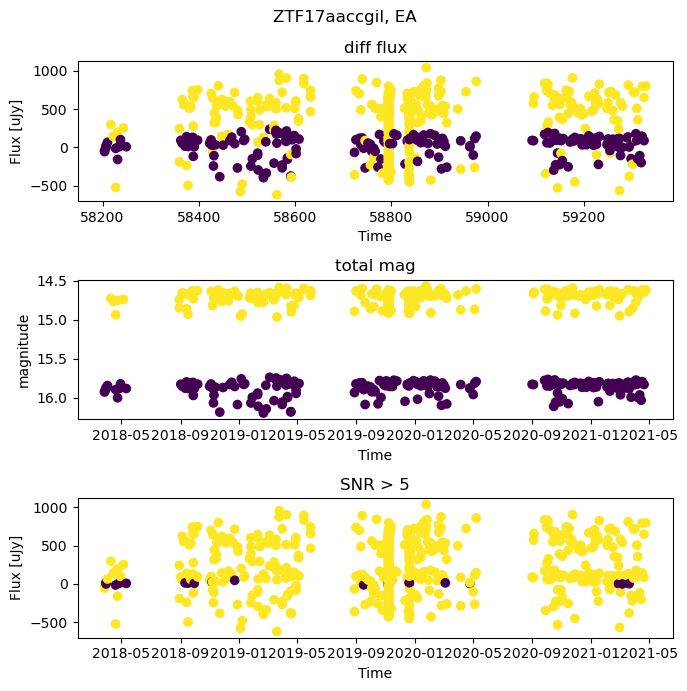

In [39]:
oid = objects_df.oid.values[0]
lc = lightcurves[lightcurves.oid == oid]

fig = plt.figure(figsize=(7, 7))
fig.set_facecolor('white')
plt.suptitle(f'{oid}, {objects_df[objects_df.oid == oid].alerceclass.values[0]}')

time = Time(lc.mjd, format='mjd')

plt.subplot(3, 1, 1)
plt.scatter(lc.mjd, lc.flux_diff_ujy, c=lc.fid)
plt.xlabel('Time')
plt.ylabel('Flux [uJy]')
plt.title('diff flux')

plt.subplot(3, 1, 2)
plt.scatter(time.to_datetime(), lc.mag_tot, c=lc.fid)
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('magnitude')
plt.title('total mag')

plt.subplot(3, 1, 3)
plt.scatter(time.to_datetime(), lc.flux_diff_ujy, 
            c=(np.abs(lc.flux_diff_ujy / lc.sigma_flux_diff_ujy) > 5).astype(int))
plt.xlabel('Time')
plt.ylabel('Flux [uJy]')
plt.title('SNR > 5')

plt.tight_layout()

## Please save the lightcurves and object info to avoid downloading data from AWS over and over

In [40]:
len(lightcurves)

11518439

In [41]:
!ls

config.py			__pycache__
download_training_set_ff.ipynb	ztf_forced_training_set_exploration.ipynb


In [42]:
lightcurves.to_pickle('lightcurves.pkl')

In [44]:
objects_df.to_pickle('objects.pkl')